Q2 skeleton:
This skeleton intends to give students some hints. You could try to use the skelton code provided to implement Q2, but feel free to use your own implmentation.

For the batch =1000 case. May update the learning rate = 0.001 instead of 0.005 to get a stabler loss and accuracy performence

1. (1 pts) Write the code for downloading and formatting the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.51MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Preprocess the data
def preprocess_data(data):
    X = [] #(60000, 784)
    Y = [] # (60000, 10)
    for image_tensor, label in data:
        X.append( (image_tensor.numpy()).reshape(784) )  #reshaping ith datapoint and transfer to numpy array
        yoh = np.zeros(10) # Convert the label into one hot vector. ie 5 = [0,0,0,0,0,1,0,0,0,0]
        yoh[label] = 1
        Y.append(yoh)
    X_train = np.array(X)
    Y_train = np.array(Y)
    return X_train,Y_train

X_train, Y_train = preprocess_data(train_data)
X_test, Y_test = preprocess_data(test_data)

In [4]:
#initialize W for random numbers for the first epoch
def initialize_weights(input_size, num_classes):
    np.random.seed(42)
    return np.random.randn(num_classes, input_size) * 0.01

def forward_pass(X, W):
    Z = np.dot(X,W)  # Linear combination
    fwb = softmax(Z)    # Apply softmax to get probabilities
    return fwb

# # Softmax for multiclass claasifyer
# def softmax(z):
#     exp_z = np.exp(z - np.max(z))
#     #print(exp_z,"expz")
#     #print(np.sum(exp_z, axis=0, keepdims=True),"sumz")
#     return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def softmax(z):
    # Subtract max value from each row (for stability)
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)



def compute_loss(y_pred, y_true, W, reg_lambda):
  # loss = 0.5 * ForbinusNorm(Y-XW)^2    +    0.5lambda * ForbinusNorm(W)^2
  error = np.linalg.norm(y_true - y_pred)
  #print(error,"error")
  reg = reg_lambda*0.5 *np.linalg.norm(W)
  #print(reg,"reg")
  totalLoss = error+reg

  return totalLoss


def compute_gradient(X, y_pred, y_true, W, reg_lambda):
    #Gradient = 𝑋_𝑇 (𝑋𝑊 − 𝑌 ) +reg, refer to lectur3, pg 50
    #m = y_true.shape[0] #should we divide by total number of samples?
    m = 1
    error = y_pred - y_true
    dW = (X.T).dot(error)
    #print(dW, "1dw")
    dW = dW/m
    dW = reg_lambda * W + dW #add the regulazation term
    #print(dW, "1dw")

    return dW


def sgd(W, grad_W, learning_rate):
  W = W - learning_rate * grad_W #W_t1 = W0 - eta*dW_0
  return W


def compute_accuracy(X, y_true, W):
    y_pred = forward_pass(X, W) #predict the value
    predicted_labels = np.argmax(y_pred, axis=1) # find the highest probablity digit. [3,1,4,1,5,9,2,6,0], 9 is largest, its index refer to 5

    true_labels = np.argmax(y_true, axis=1) # do the samething as predicted_labelds, but for true value

    correct_predictions = np.sum(predicted_labels == true_labels) # the total number of correct prediction
    accuracy = correct_predictions / len(y_true) # the % of correct prediction. CorrectClassified / totaSlamples

    return accuracy


def train_classifier(X_train, y_train, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, x_test = 0, y_test = 0):
    W = initialize_weights(num_classes, input_size)  # Initialize weights
    m = X_train.shape[0]  # Number of training examples
    EpochLoss = []

    # epoch training
    accuracies = []
    for epoch in range(num_epochs):
        # Suppose we have 60k datapoints, in each epoch SGD choose first 6k datapoints to process and update the W, and choose 2nd 6kdatapoint and update W again. Once it finish all 60k datapoint, it start next epoch
        # The advantage is each 6k datapoints(small portion, subset of original dataset) can update its W instead of run all 60k. Saved time
        # To make the 6k datapoints valid, its wise to randomly choose datapoints, since if dataset is ordered, the 6k samples is very bias since it doesnt cover info inthe later region

        # Do we need to shuffle dataset? I believe thedataset is already in random order
        # indices = np.random.permutation(m)
        # X_train_shuffled = X_train[indices]
        # y_train_shuffled = y_train[indices]

        X_train_shuffled = X_train
        y_train_shuffled = y_train

        # batch a subset
        for i in range(0, m, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            # print(X_batch.shape)
            # print(y_batch.shape)

            y_pred = forward_pass(X_batch, W) # predict the digit, prediction

            grad_W = compute_gradient(X_batch, y_pred, y_batch, W, reg_lambda) # calculate dW

            W = sgd(W, grad_W, learning_rate) # Update W

        # Print loss every few epochs
        if epoch % 10 == 0 or epoch in[0,1,2,3,4,5]:
            loss = compute_loss(y_pred, y_batch, W, reg_lambda)
            EpochLoss.append(loss)
            print("Epoch: ", epoch, "Loss: ", loss)
            accuracy = compute_accuracy(x_test, y_test, W)
            #print(accuracy," accu each")
            accuracies.append(accuracy)
            #print(accuracies," accu list")

    accuracy = compute_accuracy(x_test, y_test, W)
    print("accuracy: ", accuracy)

    return EpochLoss, accuracies, W #return the LOSS over each few(10) epoch, and the last Weight used

In [5]:
#Hand epoch 1

W1 = initialize_weights(10, 784)
y_pred1 = forward_pass(X_train, W1)
dW1 = compute_gradient(X_train, y_pred1, Y_train, W1, 0.01)
W2 = sgd(W1, dW1, 0.01)
loss1 = compute_loss(y_pred1, Y_train, W1, 0.01)
print(loss1)

232.99971641228606


In [6]:
#Hand epoch 2

y_pred2 = forward_pass(X_train, W2)
dW2 = compute_gradient(X_train, y_pred2, Y_train, W2, 0.01)
W3 = sgd(W2, dW2, 0.01)
loss2 = compute_loss(y_pred2, Y_train, W2, 0.01)

loss2

214.0583003751472

## The role of batch size: Run your code with batch sizes B = 1, 10, 100, 1000. For each batch
size,
• determine a good choice of learning rate
• pick ITR sufficiently large to ensure the (approximate) convergence of the training loss
• Plot the progress of training loss (y-axis) as a function of the iteration counter t (x-axis)
• Report how long the training takes (in seconds).
• Plot the progress of the test accuracy (y-axis) as a function of the iteration counter t (x-axis)

In [7]:
#Batch = 1
num_classes = 10
input_size = 784
batch_size = 1
num_epochs = 50
learning_rate = 0.005
reg_lambda = 0.001

import time
batch1S = time.time() #batch1 time start


batch1= train_classifier(X_train, Y_train, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)
batch1E = time.time() #batch1 time end
batch1TD = batch1E - batch1S


# print(X_val.shape)
# print(y_val.shape)
# print(X_train_small.shape)
# print(y_train_small.shape)

Epoch:  0 Loss:  0.31757726391972496
Epoch:  1 Loss:  0.29444946611588185
Epoch:  2 Loss:  0.2833762981492291
Epoch:  3 Loss:  0.2770517757674071
Epoch:  4 Loss:  0.2731651160634607
Epoch:  5 Loss:  0.27071819395677454
Epoch:  10 Loss:  0.2669269549557239
Epoch:  20 Loss:  0.26650798823478683
Epoch:  30 Loss:  0.26650574498549706
Epoch:  40 Loss:  0.26650591035792415
accuracy:  0.9103


In [8]:
#Batch = 10
num_classes = 10
input_size = 784
batch_size = 10
num_epochs = 50
learning_rate = 0.005

reg_lambda = 0.001

batch10S = time.time() #batch1 time start

batch10= train_classifier(X_train, Y_train, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)


batch10E = time.time() #batch1 time end
batch10TD = batch10E - batch10S




Epoch:  0 Loss:  0.39796504069167404
Epoch:  1 Loss:  0.3480134629189122
Epoch:  2 Loss:  0.32339620183569323
Epoch:  3 Loss:  0.3083371352366459
Epoch:  4 Loss:  0.2983578316930637
Epoch:  5 Loss:  0.2915059168714281
Epoch:  10 Loss:  0.27802510145672993
Epoch:  20 Loss:  0.27446914741229445
Epoch:  30 Loss:  0.27380851878867674
Epoch:  40 Loss:  0.2734494110083452
accuracy:  0.916


In [9]:
accuracy = compute_accuracy(X_test, Y_test, W1)


In [10]:
#Batch = 100
num_classes = 10
input_size = 784
batch_size = 100
num_epochs = 50
learning_rate = 0.005
reg_lambda = 0.001

batch100S = time.time() #batch1 time start

batch100= train_classifier(X_train, Y_train, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)

batch100E = time.time() #batch1 time end
batch100TD = batch100E - batch100S



Epoch:  0 Loss:  3.57855299009248
Epoch:  1 Loss:  3.364595419069503
Epoch:  2 Loss:  3.240889242537828
Epoch:  3 Loss:  3.152314899399336
Epoch:  4 Loss:  3.0829881859285364
Epoch:  5 Loss:  3.026172869902858
Epoch:  10 Loss:  2.8450608595735383
Epoch:  20 Loss:  2.693061412693994
Epoch:  30 Loss:  2.6300690607484327
Epoch:  40 Loss:  2.5966563472374613
accuracy:  0.9165


In [11]:
#Batch = 1000
num_classes = 10
input_size = 784
batch_size = 1000
num_epochs = 50
learning_rate = 0.005
reg_lambda = 0.001

batch1000S = time.time() #batch1 time start

batch1000= train_classifier(X_train, Y_train, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)

batch1000E = time.time() #batch1 time end
batch1000TD = batch1000E - batch1000S

print("finished")


Epoch:  0 Loss:  10.735614012469915
Epoch:  1 Loss:  10.025584992349584
Epoch:  2 Loss:  11.175939052547776
Epoch:  3 Loss:  9.714057234746159
Epoch:  4 Loss:  10.022713856930343
Epoch:  5 Loss:  14.580147719707051
Epoch:  10 Loss:  9.08634055999267
Epoch:  20 Loss:  8.931759107398992
Epoch:  30 Loss:  10.506103980909392
Epoch:  40 Loss:  11.273456953454867
accuracy:  0.9124
finished


In [12]:
times = [batch1TD,batch10TD,batch100TD,batch1000TD]
#mistakely subtract time start and time end. should negate each value
labels = ['batch1', 'batch10', 'batch100', 'batch1000']
for i in range(len(times)):
  print(labels[i], "Running time:", times[i])



batch1 Running time: 140.61276292800903
batch10 Running time: 23.531983852386475
batch100 Running time: 12.94945478439331
batch1000 Running time: 10.854637384414673


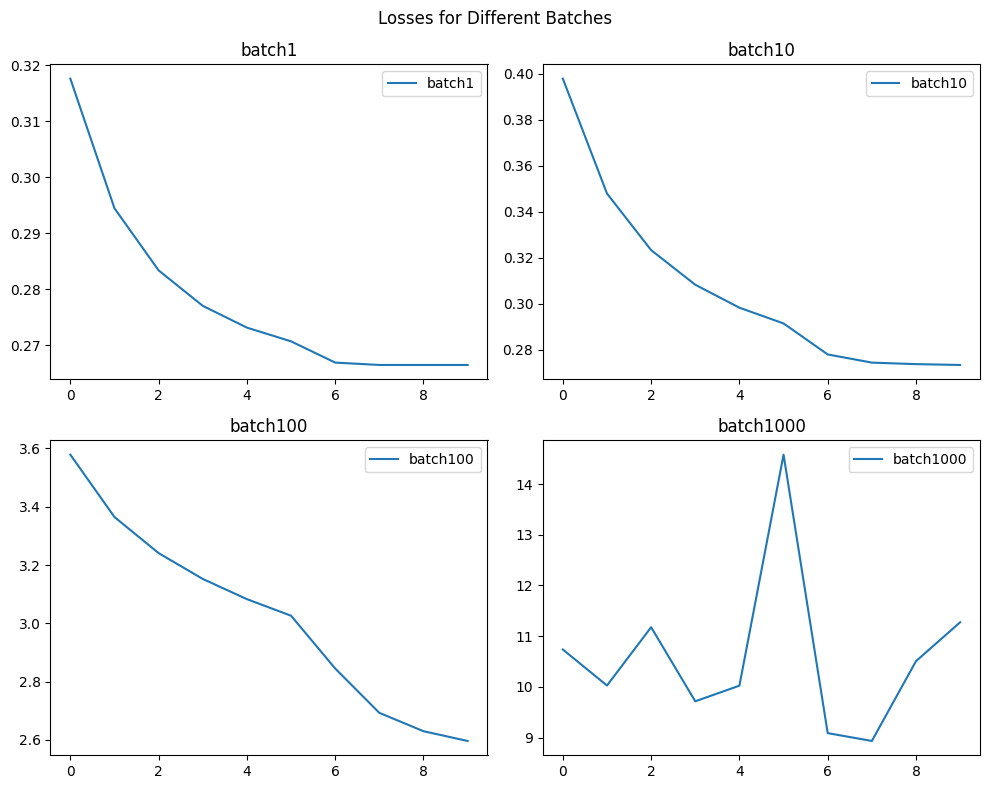

In [13]:
losses = [batch1[0], batch10[0], batch100[0], batch1000[0]]

labels = ['batch1', 'batch10', 'batch100', 'batch1000']

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

# Loop through the losses and plot each
for i, loss in enumerate(losses):
    axs[i].plot(loss, label=labels[i])
    axs[i].set_title(labels[i])
    axs[i].legend()

fig.suptitle('Losses for Different Batches')
plt.tight_layout()
plt.show()


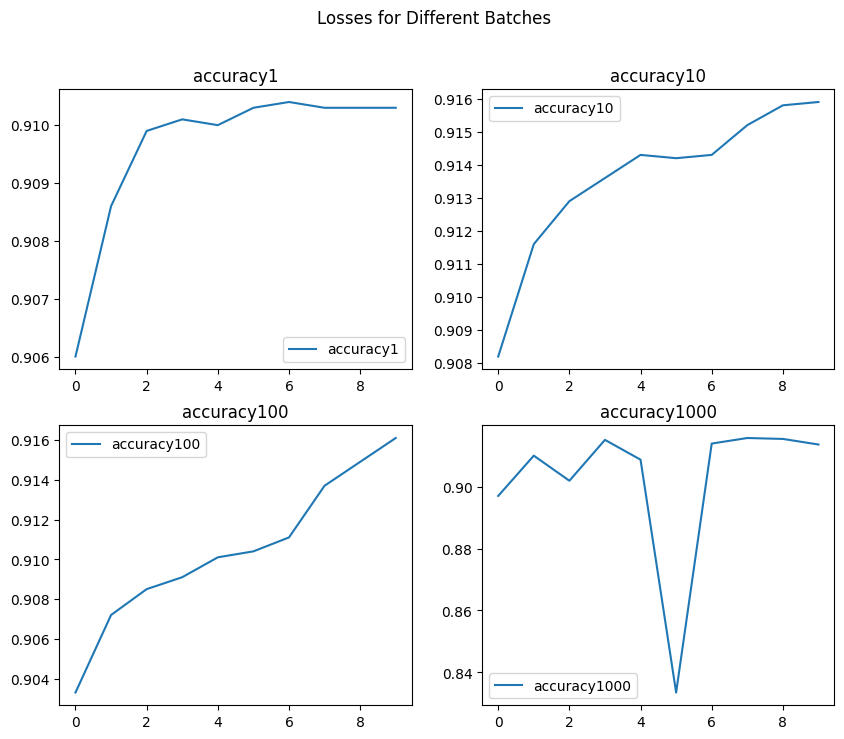

In [14]:
accus = [batch1[1], batch10[1], batch100[1], batch1000[1]]

labels2 = ['accuracy1', 'accuracy10', 'accuracy100', 'accuracy1000']

# Subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

# Loop through the losses and plot each
for i, accu in enumerate(accus):
    axs[i].plot(accu, label=labels2[i])
    axs[i].set_title(labels2[i])
    axs[i].legend()

fig.suptitle('Losses for Different Batches')
plt.show()


In [15]:
accus

[[0.906, 0.9086, 0.9099, 0.9101, 0.91, 0.9103, 0.9104, 0.9103, 0.9103, 0.9103],
 [0.9082,
  0.9116,
  0.9129,
  0.9136,
  0.9143,
  0.9142,
  0.9143,
  0.9152,
  0.9158,
  0.9159],
 [0.9033,
  0.9072,
  0.9085,
  0.9091,
  0.9101,
  0.9104,
  0.9111,
  0.9137,
  0.9149,
  0.9161],
 [0.897, 0.91, 0.9019, 0.9151, 0.9087, 0.8335, 0.9139, 0.9157, 0.9154, 0.9136]]

## the role of training dataset size:
Let us reduce the training dataset size. Instead of
N = 60, 000, let us pick a subset S′ of size N ′ from the original dataset without replacement and
uniformly at random. Fix batch size to B = 100. Repeat the steps above for N ′ ∈ {100, 500, 1000, 10000}.
Comment on the accuracy as a function of dataset size

In [16]:
# n = 100
n = 101
num_classes = 10
input_size = 784
batch_size = 100
num_epochs = 100
learning_rate = 0.005
reg_lambda = 0.001


X_train100, Y_train100 = X_train[0:n], Y_train[0:n]
#X_train100.shape
n100= train_classifier(X_train100, Y_train100, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)


Epoch:  0 Loss:  1.0214809556576379
Epoch:  1 Loss:  0.9897318300479594
Epoch:  2 Loss:  0.9608164426776492
Epoch:  3 Loss:  0.9182179064857812
Epoch:  4 Loss:  0.8762606387855494
Epoch:  5 Loss:  0.82650101731418
Epoch:  10 Loss:  0.599432145379703
Epoch:  20 Loss:  0.3231800278068929
Epoch:  30 Loss:  0.21045245417621108
Epoch:  40 Loss:  0.1548705284456581
Epoch:  50 Loss:  0.1224209838949591
Epoch:  60 Loss:  0.10129460386967794
Epoch:  70 Loss:  0.0864922777740286
Epoch:  80 Loss:  0.07556362066761493
Epoch:  90 Loss:  0.06717347460857884
accuracy:  0.6834


In [17]:
# n =500
n = 501
num_classes = 10
input_size = 784
batch_size = 100
num_epochs = 100
learning_rate = 0.005

reg_lambda = 0.001

# batch10S = time.time() #batch1 time start

X_train500, Y_train500 = X_train[0:n], Y_train[0:n]
#X_train100.shape
n500 = train_classifier(X_train500, Y_train500, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)


Epoch:  0 Loss:  0.9826386639282493
Epoch:  1 Loss:  1.0473567432479098
Epoch:  2 Loss:  1.0669282052858453
Epoch:  3 Loss:  1.0712127470275405
Epoch:  4 Loss:  1.0676760992939114
Epoch:  5 Loss:  1.059711804114811
Epoch:  10 Loss:  0.9973151930864419
Epoch:  20 Loss:  0.8263696333198435
Epoch:  30 Loss:  0.6501118793875506
Epoch:  40 Loss:  0.5171155833505483
Epoch:  50 Loss:  0.4238459197608712
Epoch:  60 Loss:  0.35725642689912634
Epoch:  70 Loss:  0.30810112529368383
Epoch:  80 Loss:  0.2706386779231052
Epoch:  90 Loss:  0.24128396721103826
accuracy:  0.8326


In [18]:
# n = 1000
n = 1001
num_classes = 10
input_size = 784
batch_size = 100
num_epochs = 100
learning_rate = 0.005

reg_lambda = 0.001

# batch10S = time.time() #batch1 time start

X_train1000, Y_train1000 = X_train[0:n], Y_train[0:n]
#X_train100.shape
n1000 = train_classifier(X_train1000, Y_train1000, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)


Epoch:  0 Loss:  0.32770654117660714
Epoch:  1 Loss:  0.28125572737917076
Epoch:  2 Loss:  0.2254229171879629
Epoch:  3 Loss:  0.18779982889176397
Epoch:  4 Loss:  0.16245264735196976
Epoch:  5 Loss:  0.14448475746049846
Epoch:  10 Loss:  0.09733351825145917
Epoch:  20 Loss:  0.05950219563876652
Epoch:  30 Loss:  0.04509564948737945
Epoch:  40 Loss:  0.03904695981797642
Epoch:  50 Loss:  0.035890852192304305
Epoch:  60 Loss:  0.033300919820572566
Epoch:  70 Loss:  0.030678994790260903
Epoch:  80 Loss:  0.02827615686684308
Epoch:  90 Loss:  0.026244672710047982
accuracy:  0.8544


In [19]:
# n =10000
n = 10001
num_classes = 10
input_size = 784
batch_size = 100
num_epochs = 100
learning_rate = 0.005

reg_lambda = 0.001

# batch10S = time.time() #batch1 time start

X_train10k, Y_train10k = X_train[0:n], Y_train[0:n]
#X_train100.shape
n10k = train_classifier(X_train10k, Y_train10k, num_classes, input_size, batch_size, num_epochs, learning_rate, reg_lambda, X_test, Y_test)


Epoch:  0 Loss:  0.006545208129109697
Epoch:  1 Loss:  0.0054451494848667
Epoch:  2 Loss:  0.005331362912078884
Epoch:  3 Loss:  0.005393130379883371
Epoch:  4 Loss:  0.005512157483428014
Epoch:  5 Loss:  0.005653954622838702
Epoch:  10 Loss:  0.006413199622143339
Epoch:  20 Loss:  0.007751352493918339
Epoch:  30 Loss:  0.008870426026452195
Epoch:  40 Loss:  0.009845412947469403
Epoch:  50 Loss:  0.010718869228332092
Epoch:  60 Loss:  0.011516100688775836
Epoch:  70 Loss:  0.012253111840670733
Epoch:  80 Loss:  0.012940651570202253
Epoch:  90 Loss:  0.013586371901295856
accuracy:  0.9034


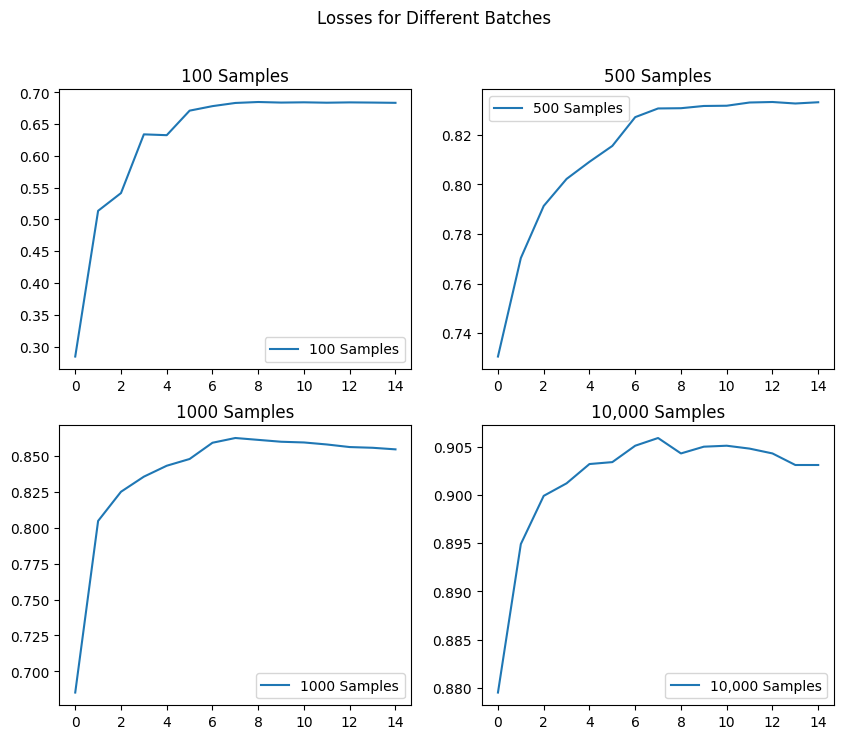

In [20]:
accus = [n100[1], n500[1], n1000[1], n10k[1]]

labels2 = ['100 Samples', '500 Samples', '1000 Samples', '10,000 Samples']

# Subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

# Loop through the losses and plot each
for i, accu in enumerate(accus):
    axs[i].plot(accu, label=labels2[i])
    axs[i].set_title(labels2[i])
    axs[i].legend()

fig.suptitle('Losses for Different Batches')
plt.show()